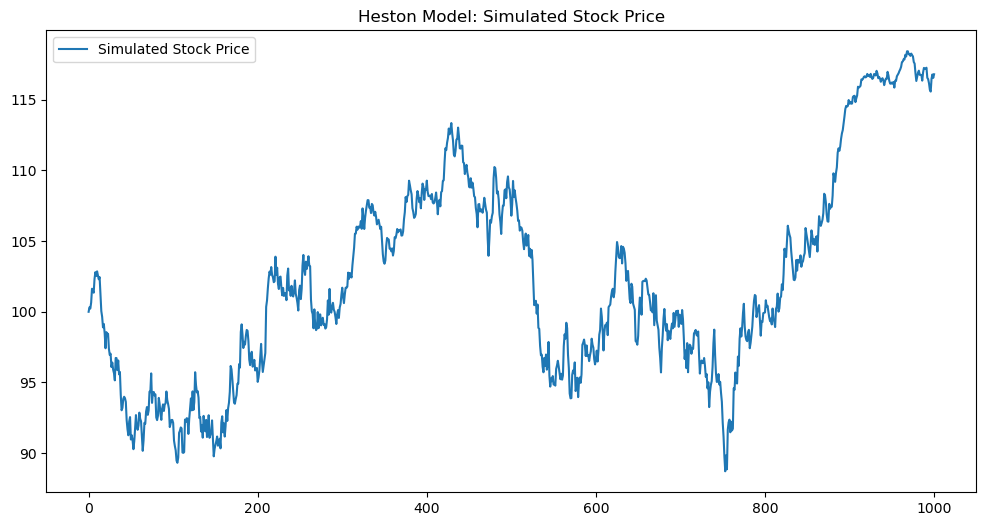

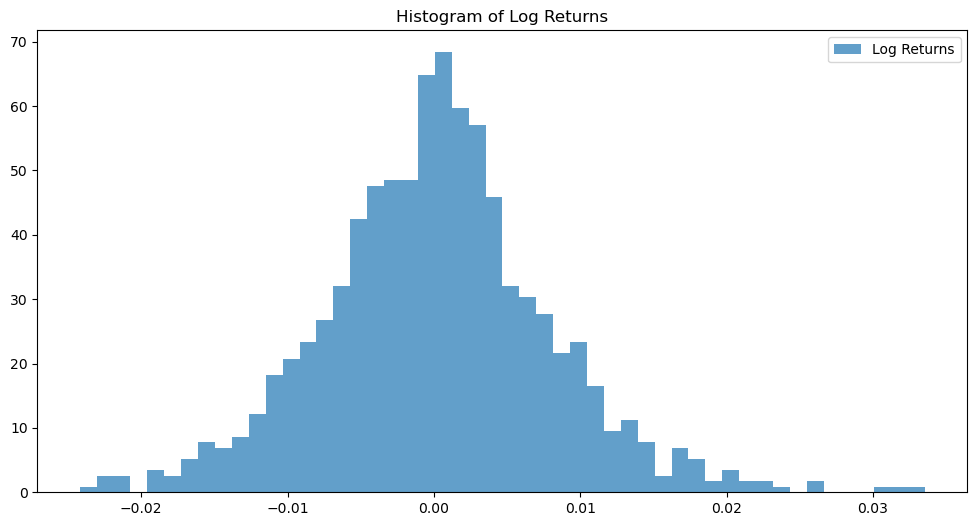

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Heston model
T = 1.0
N = 1000
dt = T / N
S0 = 100
v0 = 0.04
rho = -0.9
kappa = 2.0
theta = 0.04
xi = 0.5
r = 0.03

np.random.seed(42)
W1 = np.random.normal(0, np.sqrt(dt), N)
W2 = np.random.normal(0, np.sqrt(dt), N)
W2 = rho * W1 + np.sqrt(1 - rho**2) * W2

S = np.zeros(N + 1)
v = np.zeros(N + 1)
S[0] = S0
v[0] = v0

for t in range(1, N + 1):
    v[t] = np.maximum(v[t-1] + kappa * (theta - v[t-1]) * dt + xi * np.sqrt(v[t-1]) * W2[t-1], 0)
    S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1]) * W1[t-1])

returns = np.diff(S) / S[:-1]

plt.figure(figsize=(12, 6))
plt.plot(S, label="Simulated Stock Price")
plt.title("Heston Model: Simulated Stock Price")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(returns, bins=50, density=True, alpha=0.7, label="Log Returns")
plt.title("Histogram of Log Returns")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


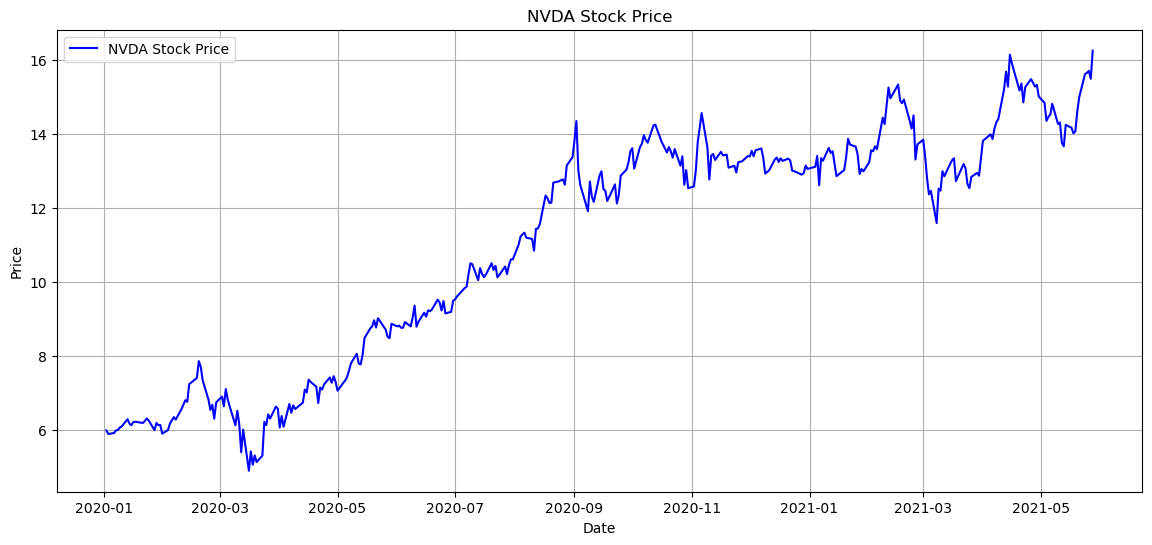

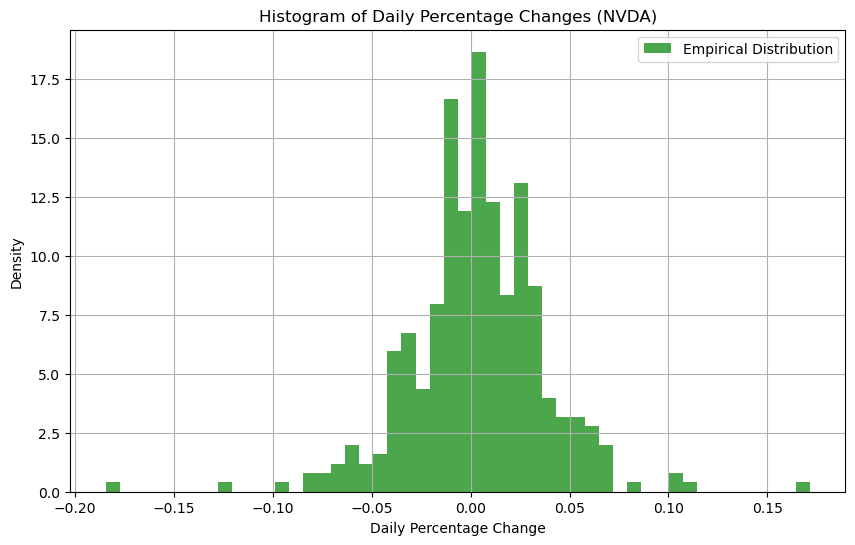

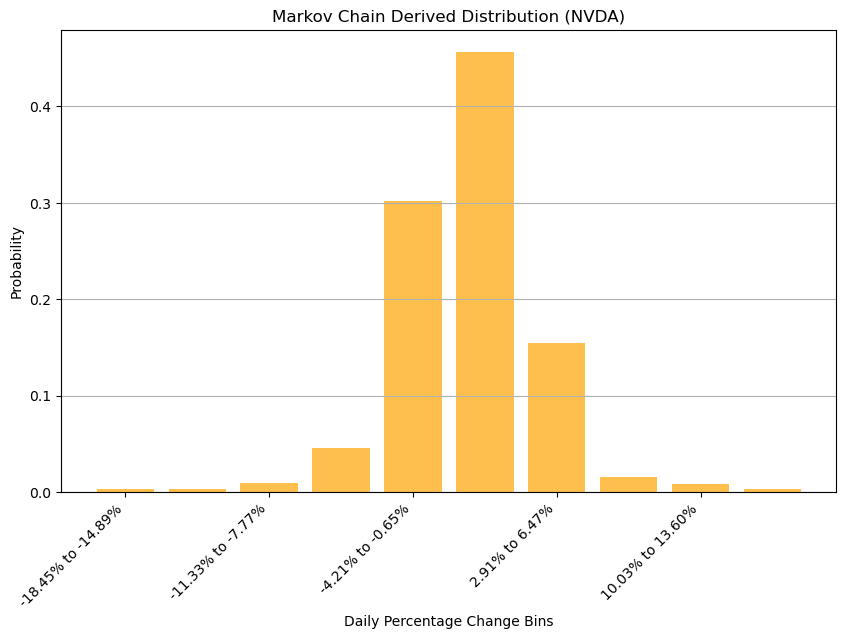

In [85]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

start = "2020-01-01"
mid = "2021-06-01"
end = "2023-01-01"

ticker = "NVDA"  
data = yf.download(ticker, start, mid)
prices = data['Close']

# Calculate daily percentage changes
daily_changes = (prices.pct_change().dropna()).values


num_bins_returns = 10
bins_returns = np.linspace(daily_changes.min(), daily_changes.max(), num_bins_returns + 1)
labels = [f"{bins_returns[i]:.2%} to {bins_returns[i + 1]:.2%}" for i in range(num_bins_returns)]
states = np.digitize(daily_changes, bins_returns) - 1
states[states >= num_bins_returns] = num_bins_returns - 1

#Create transition matrix
num_states = num_bins_returns
transition_matrix = np.zeros((num_states, num_states))

for i in range(len(states) - 1):
    transition_matrix[states[i], states[i + 1]] += 1

# Normalize rows to get probabilities
transition_matrix_returns = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

#Simulate a Markov chain to approximate the longterm distribution
num_steps = 10000
current_state = np.random.choice(range(num_states))
state_counts = Counter()

for _ in range(num_steps):
    state_counts[current_state] += 1
    current_state = np.random.choice(range(num_states), p=transition_matrix_returns[current_state])

# Normalize to derive the stationary distribution
stationary_distribution_returns = np.array([state_counts[i] for i in range(num_states)]) / num_steps

# Plot stock price
plt.figure(figsize=(14, 6))
plt.plot(prices, label=f"{ticker} Stock Price", color="blue")
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(daily_changes, bins=50, density=True, alpha=0.7, color='green', label="Empirical Distribution")
plt.title(f"Histogram of Daily Percentage Changes ({ticker})")
plt.xlabel("Daily Percentage Change")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
x_positions = range(num_states)
plt.bar(x_positions, stationary_distribution_returns, alpha=0.7, color='orange')
plt.xticks(x_positions[::2], labels[::2], rotation=45, ha='right')  # Space out x-axis labels
plt.title(f"Markov Chain Derived Distribution ({ticker})")
plt.xlabel("Daily Percentage Change Bins")
plt.ylabel("Probability")
plt.grid(axis='y')
plt.show()


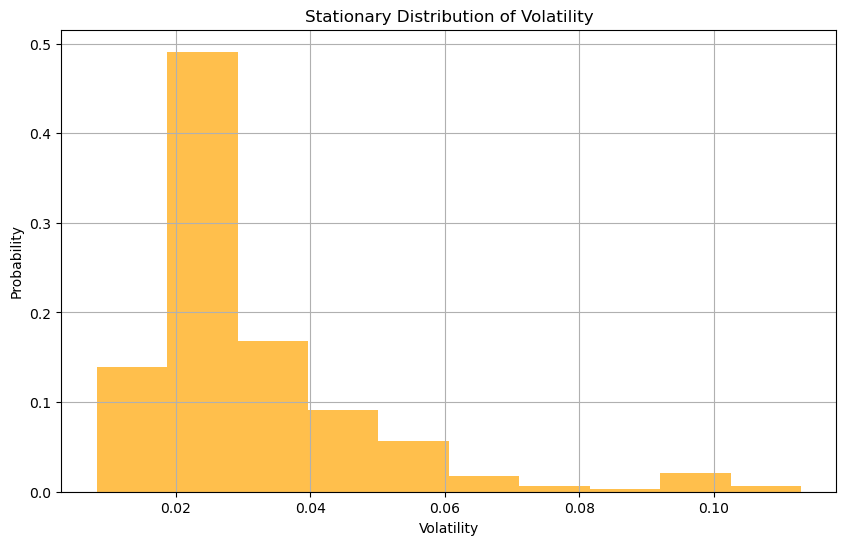

In [86]:
returns = prices.pct_change().dropna()
volatility = returns.rolling(window=10).std().dropna().values  # Convert to NumPy array

num_bins_volitility = 10

bins_volitility = np.linspace(volatility.min(), volatility.max(), num_bins_volitility + 1)
volatility_states = np.digitize(volatility, bins_volitility) - 1
volatility_states[volatility_states >= num_bins_volitility] = num_bins_volitility - 1

num_states = num_bins_volitility
transition_matrix_volatility = np.zeros((num_states, num_states))

for i in range(len(volatility_states) - 1):
    transition_matrix_volatility[volatility_states[i], volatility_states[i + 1]] += 1

# Normalize rows to get probabilities and handle NaN values
transition_matrix_volatility = transition_matrix_volatility / transition_matrix_volatility.sum(axis=1, keepdims=True)
transition_matrix_volatility = np.nan_to_num(transition_matrix_volatility)

eigenvalues, eigenvectors = np.linalg.eig(transition_matrix_volatility.T)
stationary_distribution_volatility = eigenvectors[:, np.isclose(eigenvalues, 1)].flatten().real
stationary_distribution_volatility /= stationary_distribution_volatility.sum()

plt.figure(figsize=(10, 6))
bin_centers = (bins_volitility[:-1] + bins_volitility[1:]) / 2
plt.bar(bin_centers, stationary_distribution_volatility, width=(bins_volitility[1] - bins_volitility[0]), alpha=0.7, color='orange')
plt.title("Stationary Distribution of Volatility")
plt.xlabel("Volatility")
plt.ylabel("Probability")
plt.grid()
plt.show()

Gernating synthetic data from the Markov distribution 

[*********************100%***********************]  1 of 1 completed


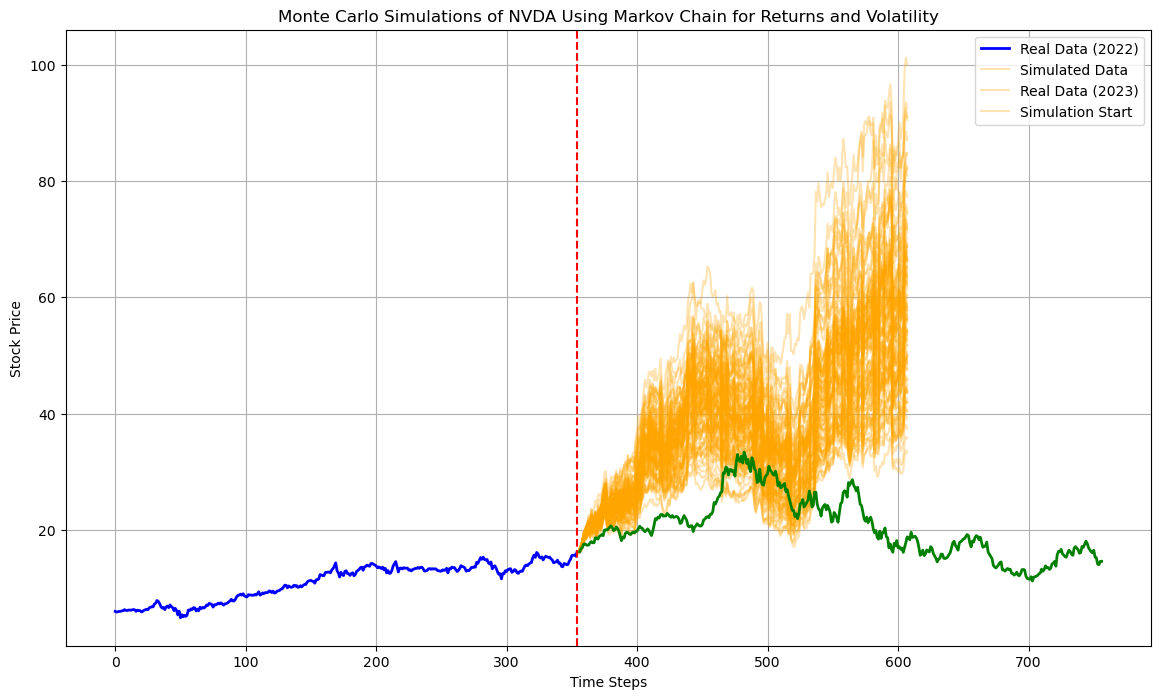

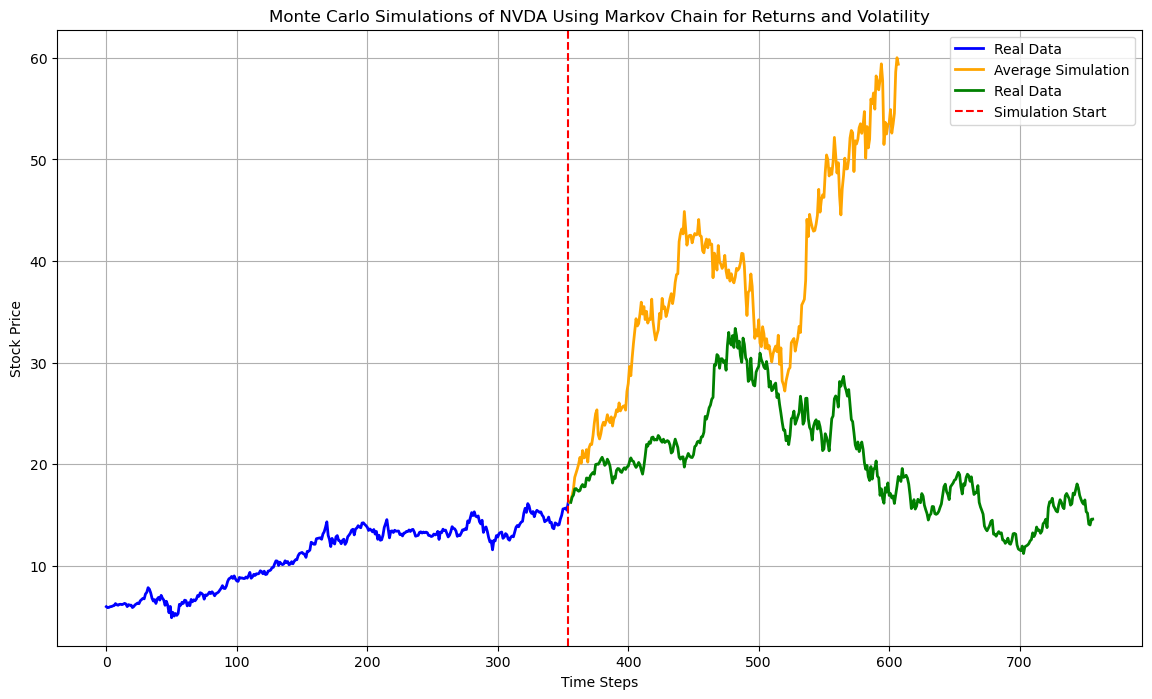

In [95]:

data_post_sim = yf.download(ticker, mid, end)
prices_post_sim = data_post_sim['Close']

T = 1.0
N = 252
dt = T / N
v0 = 0.04
rho = -0.7
kappa = 2.0
theta = 0.04
xi = 0.5
r = 0.03
num_simulations = 100  

def generate_markov_states(num_steps, num_bins, bins, transition_matrix, stationary_distribution):
    states = []
    current_state = np.random.choice(range(num_bins), p=stationary_distribution)
    for _ in range(num_steps):
        states.append(np.random.uniform(bins[current_state], bins[current_state + 1]))
        current_state = np.random.choice(range(num_bins), p=transition_matrix[current_state])
    return np.array(states)

def heston_mc_markov(S0, num_simulations, markov_returns, markov_volatility):
    paths = np.zeros((num_simulations, N + 1))
    paths[:, 0] = S0
    for sim in range(num_simulations):
        for t in range(1, N + 1):
            dW1 = np.random.normal(0, np.sqrt(dt))
            vol_t = markov_volatility[t - 1]
            paths[sim, t] = paths[sim, t - 1] * (1 + markov_returns[t - 1] + np.sqrt(vol_t) * dW1)
    return paths

markov_returns = generate_markov_states(N, num_bins_returns, bins_returns, transition_matrix_returns, stationary_distribution_returns)
markov_volatility = generate_markov_states(N, num_bins_volitility, bins_volitility, transition_matrix_volatility, stationary_distribution_volatility)

S0 = prices.iloc[-1]
stock_paths = heston_mc_markov(S0, num_simulations, markov_returns, markov_volatility)

plt.figure(figsize=(14, 8))
time_real_pre_sim = np.arange(len(prices))
plt.plot(time_real_pre_sim, prices, color="blue", linewidth=2, label="Real Data (2022)")

time_sim = np.arange(len(prices), len(prices) + N + 1)
for sim in range(num_simulations):
    plt.plot(time_sim, stock_paths[sim], alpha=0.3, color="orange")

time_real_post_sim = np.arange(len(prices) + 1, len(prices) + 1 + len(prices_post_sim))
plt.plot(time_real_post_sim, prices_post_sim, color="green", linewidth=2, label="Real Data (2023)")

plt.title(f"Monte Carlo Simulations of {ticker} Using Markov Chain for Returns and Volatility")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.axvline(x=len(prices) - 1, color='red', linestyle='--', label='Start of Simulations')
plt.legend(["Real Data (2022)", "Simulated Data", "Real Data (2023)", "Simulation Start"])
plt.grid()
plt.show()

#plot the average of the simulated paths
plt.figure(figsize=(14, 8))
time_real_pre_sim = np.arange(len(prices))
plt.plot(time_real_pre_sim, prices, color="blue", linewidth=2, label="Real Data (2022)")

time_sim = np.arange(len(prices), len(prices) + N + 1)
plt.plot(time_sim, stock_paths.mean(axis=0), color="orange", linewidth=2, label="Average Simulation")

time_real_post_sim = np.arange(len(prices) + 1, len(prices) + 1 + len(prices_post_sim))
plt.plot(time_real_post_sim, prices_post_sim, color="green", linewidth=2, label="Real Data (2023)")

plt.title(f"Monte Carlo Simulations of {ticker} Using Markov Chain for Returns and Volatility")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.axvline(x=len(prices) - 1, color='red', linestyle='--', label='Start of Simulations')
plt.legend(["Real Data", "Average Simulation", "Real Data", "Simulation Start"])
plt.grid()
plt.show()
